There are two Ramani et al. datasets, one uses all libraries (used for benchmarking in scVI-3D (3DVI) paper) and one with only ML1 & ML3 library (Used in scHiCluster, Higashi and Fast-Higashi manuscript). We refer to them as ramani_all and ramani_subset. We'll run Fast-Higashi on both of these dataset. Let's try ramani_subset first. 

NOTE: for this dataset, because different library contains non-overlapping cell types and have different coverage, it's hard to evaluate batch correction / coverage correction method on this dataset, because the technical variability is highly corrrelated with biological ones.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_sciHiC_ramani_1m.JSON"

In [3]:
# initialize the model
wrapper = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=True, # dataset with low coverage, turn on conv
                      do_rwr=True, # dataset with low coverage, turn on partial rwr
                      do_col=False,
                      no_col=False)


setting to gpu:1


In [4]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper.chrom_list[0])):
    start = time.time()
    wrapper.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/620 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 5.04 s


In [5]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper.prep_dataset(batch_norm=True) # when there's a batch_id given in the JSON, it will try to pre-correct batch related coverage bias / off-diag ratio bias
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 458 bad 162 total: 620
cache file = /home/rzhang/Higashi/Temp/sciHiC_ramani_1m/cache_intra_1000000_offdiag_100_.pkl


packing sparse mtx into sparse tensors:   0%|          | 0/23 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/23 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/sciHiC_ramani_1m/cache_intra_1000000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.024508743583174338
sparsity below threshold, automatically col_normalize
do_conv True do_rwr True do_col True
recommend_bs_cell [458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458, 458] pinning memory
packing sparse mtx takes: 7.19 s


In [6]:

wrapper.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=64, # there are only a little number of cells, so adjust the rank accordingly
                  n_iter_parafac=1,
                  tol=2e-5 # In the original manuscript, we use this 3e-4 tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. For this dataset, it leads to more robust results to the initialization
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper.load_model(extra="",
                   rank=64,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_64_niterp_1_
n_iter_parafac 1
time elapsed: 0.00


initializing params:   0%|          | 0/23 [00:00<?, ?it/s]

rwr iters: [5 5 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
time elapsed: 10.30
finish init
Starting iteration 0

PARAFAC2 re=10.547 takes 2.0s
Starting iteration 1

PARAFAC2 re=0.337 9.99e-01 variation min1.0e+00 at chrom 20, max1.0e+00 at chrom 0 takes 1.9s
Starting iteration 2

PARAFAC2 re=0.331 3.98e-02 variation min2.4e-02 at chrom 4, max8.4e-02 at chrom 8 takes 1.9s
Starting iteration 3

PARAFAC2 re=0.326 2.89e-02 variation min2.5e-02 at chrom 22, max3.8e-02 at chrom 15 takes 1.9s
Starting iteration 4

PARAFAC2 re=0.324 1.31e-02 variation min9.9e-03 at chrom 20, max2.0e-02 at chrom 16 takes 1.9s
Starting iteration 5

PARAFAC2 re=0.323 6.58e-03 variation min5.0e-03 at chrom 13, max1.1e-02 at chrom 16 takes 1.9s
Starting iteration 6

PARAFAC2 re=0.322 3.94e-03 variation min3.0e-03 at chrom 13, max6.9e-03 at chrom 16 takes 1.9s
Starting iteration 7

PARAFAC2 re=0.321 2.71e-03 variation min2.1e-03 at chrom 22, max4.9e-03 at chrom 16 takes 2.0s
Starting iteration 8

PARAFAC2 re=0.321 2

In [7]:
# getting embedding
embed = wrapper.fetch_cell_embedding(final_dim=64,
                                     restore_order=False)

# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


Index(['index', 'cell type', 'coverage_fh'], dtype='object')


2022-11-28 14:06:56.286584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


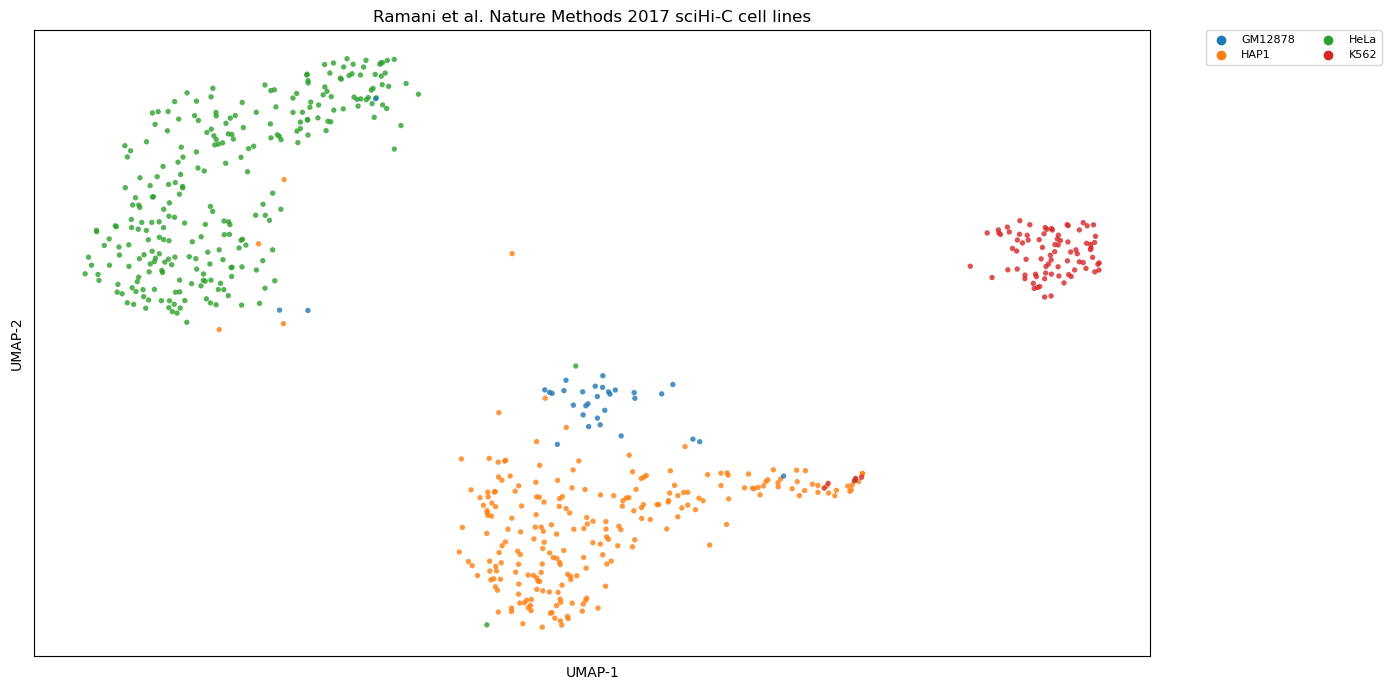

In [8]:
# Check available label information
print (wrapper.label_info.columns)
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=15, random_state=0, min_dist=0.1).fit_transform(embedding)

fig = plt.figure(figsize=(14, 7))
col = 'cell type'
ax=sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper.label_info[col], s=15, alpha=0.8, linewidth=0, palette=None, hue_order=np.unique(wrapper.label_info[col]))
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, prop={'size':8})
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title( "Ramani et al. Nature Methods 2017 sciHi-C cell lines")
plt.tight_layout()
plt.show()



OK, Now let's try ramani_all

In [9]:
from fasthigashi.FastHigashi_Wrapper import *
# Set the path to the configuration file, change it accordingly
# The format of the config file is the same as the Higashi config JSON
config = "/home/rzhang/fast_higashi_git/config_dir/config_sciHiC_ramani_all_1m.JSON"

In [10]:
# initialize the model
wrapper_all = FastHigashi(config_path=config,
                      path2input_cache=None, # when setting at None, will use the temp_dir on the JSON file
                      path2result_dir=None, # same as above
                      off_diag=100,
                      filter=True,
                      do_conv=True, # dataset with low coverage, turn on conv
                      do_rwr=True, # dataset with low coverage, turn on partial rwr
                      do_col=False,
                      no_col=False)


setting to gpu:5


In [11]:
# From contact pairs to the sparse matrices and store them on disk
if not os.path.exists(os.path.join(wrapper_all.temp_dir, "raw", "%s_sparse_adj.npy" % wrapper_all.chrom_list[0])):
    start = time.time()
    wrapper_all.fast_process_data()
    print("contact pairs to sparse mtx takes: %.2f s" % (time.time() - start))


generating start/end dict for chromosome
extracting from filelist.txt


  0%|          | 0/2271 [00:00<?, ?it/s]

fast process finishes
contact pairs to sparse mtx takes: 16.51 s


In [12]:
# packing data from sparse matrices to sparse tensors
start = time.time()
wrapper_all.prep_dataset(batch_norm=True) # when there's a batch_id given in the JSON, it will try to pre-correct batch related coverage bias / off-diag ratio bias
print("packing sparse mtx takes: %.2f s" % (time.time() - start))

total number of cells that pass qc check 1584 bad 687 total: 2271
cache file = /home/rzhang/Higashi/Temp/sciHiC_ramani_all_1m/cache_intra_1000000_offdiag_100_.pkl
will do per batch normalization


packing sparse mtx into sparse tensors:   0%|          | 0/23 [00:00<?, ?it/s]

Sorting indices in sparse tensors:   0%|          | 0/23 [00:00<?, ?it/s]

saving cached input to /home/rzhang/Higashi/Temp/sciHiC_ramani_all_1m/cache_intra_1000000_offdiag_100_.pkl
gpu mem
c_nvmlMemory_t(total: 25757220864 B, free: 25430523904 B, used: 326696960 B)
sparsity 0.025970532506857172
sparsity below threshold, automatically col_normalize
do_conv True do_rwr True do_col True
recommend_bs_cell [1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584, 1584] pinning memory
packing sparse mtx takes: 18.21 s


In [13]:

wrapper_all.run_model(extra="", # can be any words, this will be appended to the model name when the model is saved. Used as an identifier.
                  rank=64,
                  n_iter_parafac=1,
                  tol=2e-5 # In the original manuscript, we use this 3e-4 tolerance, but later we found that setting it to smaller ones might lead to better performance on some data. For this dataset, it leads to more robust results to the initialization
                  )

# loading existing trained models
# This operation is optional when the model is just trained
wrapper_all.load_model(extra="",
                   rank=64,
                   n_iter_parafac=1
                   )

dim1_0.6_rank_64_niterp_1_
n_iter_parafac 1
time elapsed: 0.99


initializing params:   0%|          | 0/23 [00:00<?, ?it/s]

rwr iters: [5 5 4 4 4 4 4 4 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
time elapsed: 25.13
finish init
Starting iteration 0

PARAFAC2 re=10.463 takes 2.5s
Starting iteration 1

PARAFAC2 re=0.349 9.99e-01 variation min1.0e+00 at chrom 21, max1.0e+00 at chrom 0 takes 2.6s
Starting iteration 2

PARAFAC2 re=0.345 2.76e-02 variation min1.8e-02 at chrom 4, max8.0e-02 at chrom 20 takes 2.6s
Starting iteration 3

PARAFAC2 re=0.343 8.94e-03 variation min7.3e-03 at chrom 6, max2.0e-02 at chrom 21 takes 2.8s
Starting iteration 4

PARAFAC2 re=0.342 3.30e-03 variation min1.4e-03 at chrom 20, max6.2e-03 at chrom 21 takes 2.7s
Starting iteration 5

PARAFAC2 re=0.342 1.73e-03 variation min-3.2e-04 at chrom 20, max3.3e-03 at chrom 5 takes 3.0s
Starting iteration 6

PARAFAC2 re=0.342 1.11e-03 variation min-4.3e-04 at chrom 20, max2.1e-03 at chrom 5 takes 2.8s
Starting iteration 7

PARAFAC2 re=0.342 7.96e-04 variation min-3.7e-04 at chrom 20, max1.5e-03 at chrom 21 takes 3.0s
Starting iteration 8

PARAFAC2 re=0.342 

Starting iteration 69

PARAFAC2 re=0.340 2.58e-05 variation min-2.6e-05 at chrom 21, max4.3e-05 at chrom 4 takes 2.9s
n_iter_para 8
Starting iteration 70

PARAFAC2 re=0.340 2.43e-05 variation min-3.4e-05 at chrom 21, max4.1e-05 at chrom 4 takes 2.9s
Starting iteration 71

PARAFAC2 re=0.340 2.68e-05 variation min-2.5e-05 at chrom 21, max4.4e-05 at chrom 4 takes 2.9s
Starting iteration 72

PARAFAC2 re=0.340 2.59e-05 variation min-2.8e-05 at chrom 21, max4.3e-05 at chrom 4 takes 2.9s
Starting iteration 73

PARAFAC2 re=0.340 2.36e-05 variation min-3.1e-05 at chrom 21, max4.0e-05 at chrom 4 takes 2.9s
converged in 73 iterations.
start transform
takes: 230.51 s


In [14]:
# getting embedding
embed = wrapper_all.fetch_cell_embedding(final_dim=64,
                                     restore_order=False)

# 'embed_l2_norm' or 'embed_l2_norm_correct_coverage_fh' usually yields the best results, the latter one represents linear correction of sequencing depth bias.
print (embed.keys())

dict_keys(['embed_all', 'embed_raw', 'embed_l2_norm', 'restore_order', 'embed_correct_coverage_fh', 'embed_l2_norm_correct_coverage_fh'])


Index(['index', 'cell type', 'batch', 'coverage_fh'], dtype='object')


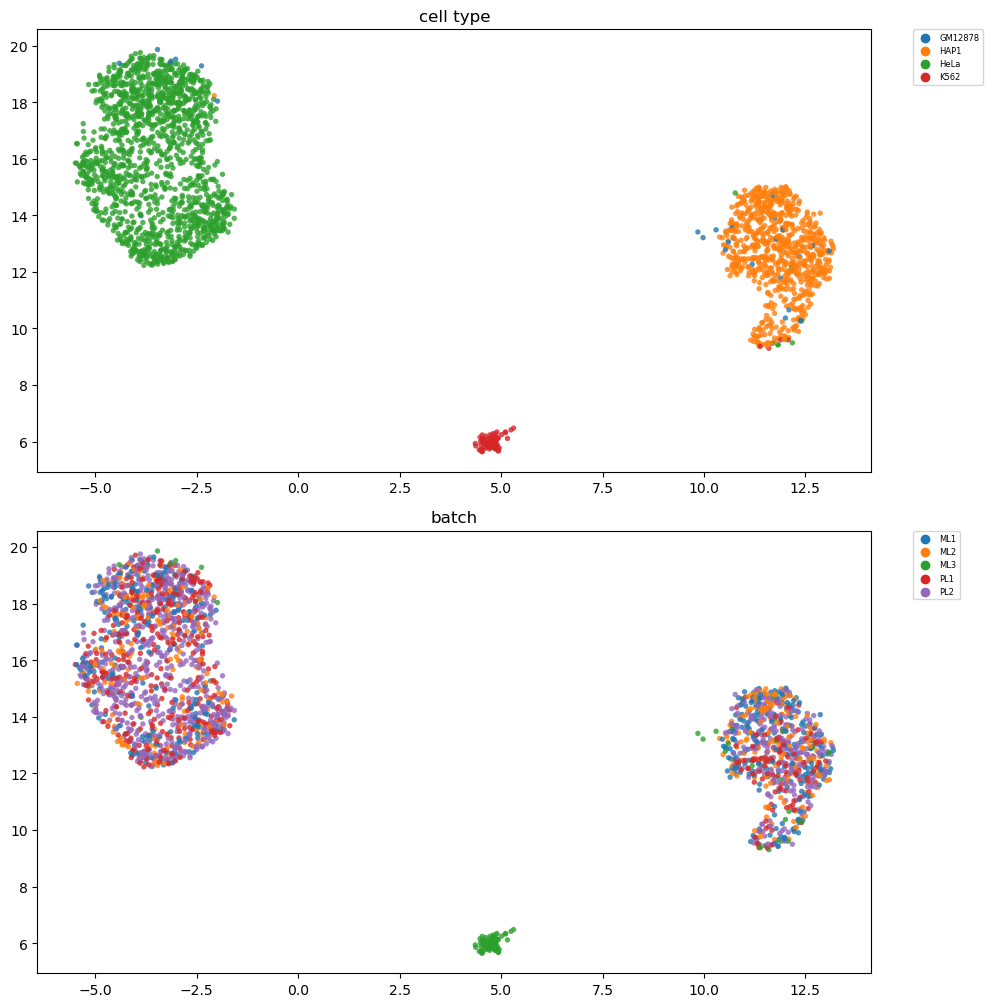

In [15]:
# Check available label information
print (wrapper_all.label_info.columns)
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
embedding = embed['embed_l2_norm']
vec = UMAP(n_components=2, n_neighbors=25, random_state=0, min_dist=0.3).fit_transform(embedding)


fig = plt.figure(figsize=(10, 30))
for col_index, col in enumerate(["cell type", "batch"]):
    ax = plt.subplot(6, 1, col_index + 1)
    sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper_all.label_info[col], ax=ax, s=15, alpha=0.8, linewidth=0, palette=None, hue_order=np.unique(wrapper_all.label_info[col]))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, 
              borderaxespad=0., ncol=int(math.ceil(len(labels)) / 40 + 1), prop={'size': 6})
    ax.set_title(col)
plt.tight_layout()
plt.show()
plt.close('all')

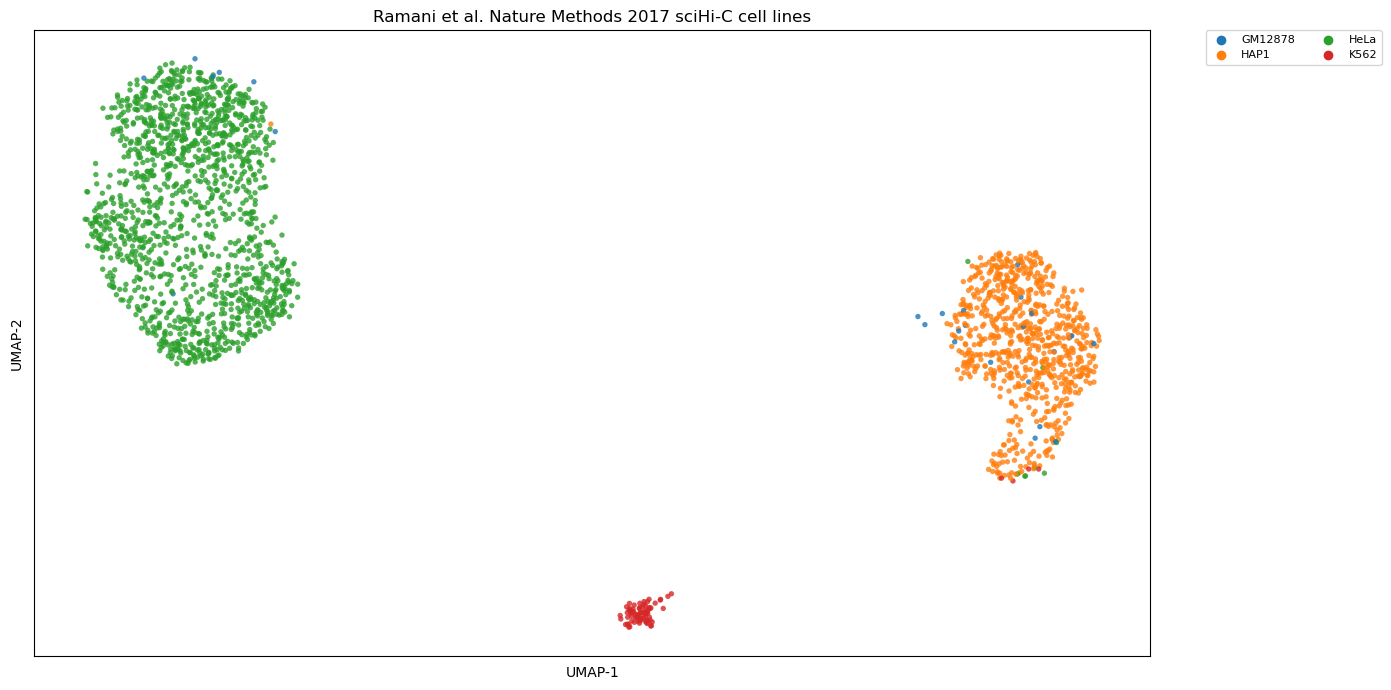

In [16]:
fig = plt.figure(figsize=(14, 7))
col = 'cell type'
ax=sns.scatterplot(x=vec[:, 0], y=vec[:, 1], hue=wrapper_all.label_info[col], s=15, alpha=0.8, linewidth=0, palette=None, hue_order=np.unique(wrapper_all.label_info[col]))
handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles=handles, labels=labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, prop={'size':8})
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title( "Ramani et al. Nature Methods 2017 sciHi-C cell lines")
plt.tight_layout()
plt.show()
